### Take annotations from TME (done with 10% mito) and cancer cell annotations (done by Sam and with 20% mito), and put them in a single object

In [1]:
import scanpy as sc
import pandas as pd
from pathlib import Path
import anndata as ad
import numpy as np

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

DPI = 300
FONTSIZE = 20  # 42

sc.settings.set_figure_params(
    scanpy=True, dpi=100, transparent=True, vector_friendly=True, dpi_save=DPI
)
from matplotlib import rcParams

rcParams["pdf.fonttype"] = 42

In [2]:
DIR2SAVE = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt/")
DIR2SAVE.mkdir(parents=True, exist_ok=True)

FIG2SAVE = DIR2SAVE.joinpath("figures/")
FIG2SAVE.mkdir(parents=True, exist_ok=True)
# set the global variable: sc.settings.figdir to save all plots
sc.settings.figdir = FIG2SAVE

### Load TME annot with 10% mt threshold

In [3]:
# load TME annot with 10% mt threshold
DIR2LOAD_10mt = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/")
adata_tme_annot = sc.read_h5ad(
    DIR2LOAD_10mt.joinpath(
        "SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_final_annotations_raw.h5ad"
    )
)

In [4]:
# remove epithelial from TME object 
adata_tme_annot = adata_tme_annot[adata_tme_annot.obs["Annotation_scVI"]!="Epithelial"].copy()

In [5]:
adata_tme_annot.obs.Annotation_scVI.value_counts()

T-NK-ILC       94164
Myeloid        36906
Plasma         24978
B              19703
Stromal         5370
Endothelial     3051
Mast            2588
Name: Annotation_scVI, dtype: int64

In [6]:
adata_tme_annot.obs.index.shape

(186760,)

In [7]:
# extract barcodes which have TME annotations
barcodes_tme = adata_tme_annot.obs.index

### Load Sam cancer annotations

In [8]:
adata_epi = sc.read_h5ad("/data/BCI-CRC/SO/data/public/primaryCRC_20mt/Harmony/SMC_KUL_Pelka_Che_Wu_CRC_epithelial_regressCC_harmonyPatient_20_filtered_harmony_inferCNV_harmony_annotation.h5ad")
adata_epi.shape

(60526, 2000)

In [10]:
adata_epi.obs.columns

Index(['Patient', 'Sample', 'Cell_type', 'Cell_subtype', 'Tissue', 'Therapy',
       'doublet_score', 'predicted_doublet', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'cell_source', 'S_score', 'G2M_score', 'phase',
       'cell_cycle_diff', 'leiden', 'cnv_leiden', 'cnv_score', 'Malignant',
       'MMRStatus', 'umap_density_MMRStatus', 'sec_anno', 'HLA_anno',
       'sec_hypoxia'],
      dtype='object')

In [11]:
barcodes_epi = adata_epi.obs.index

In [12]:
# Create Annotation_scVI column 
adata_epi.obs["Annotation_scVI"] = "Epithelial"

In [13]:
# rename sam column to epi_annot
adata_epi.obs.rename(
    columns={"Cell_subtype": "Annotation_scVI_detailed"}, inplace=True
)

In [14]:
adata_epi.obs.columns

Index(['Patient', 'Sample', 'Cell_type', 'Annotation_scVI_detailed', 'Tissue',
       'Therapy', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts',
       'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'pct_counts_ribo', 'cell_source', 'S_score', 'G2M_score', 'phase',
       'cell_cycle_diff', 'leiden', 'cnv_leiden', 'cnv_score', 'Malignant',
       'MMRStatus', 'umap_density_MMRStatus', 'sec_anno', 'HLA_anno',
       'sec_hypoxia', 'Annotation_scVI'],
      dtype='object')

### Create a list of barcodes to consider (so we only keep the cells we annotated, processed, filtered, me with threshold of mt at 10, sam with thrreshold at 20)

In [15]:
adata_tme_annot.obs.index.shape[0] + adata_epi.obs.index.shape[0]

247286

In [16]:
#barcodes2consider = barcodes_tme.union(barcodes_epi, sort=False)
barcodes2consider = barcodes_epi.union(barcodes_tme, sort=False)

In [17]:
barcodes2consider.shape

(247283,)

there are 3 cell barcodes "missing", because they overlap between the analysis of the TME with mt 10% and the analysis of the cancer cells with mt 20% 

### load clustering with 20mt all data 

In [18]:
# load clustering with 20mt all data 
DIR2LOAD_20mt = Path("/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/20mt/annotation_global/")
adata = sc.read_h5ad(DIR2LOAD_20mt.joinpath("SMC_KUL_Pelka_Che_Wu_CRC_integrated_scvi_hvg_clustering.h5ad"))

In [19]:
adata.shape

(328063, 2000)

In [20]:
adata.obs.Annotation_scVI.value_counts()

T-NK-ILC       116579
Epithelial      91114
Myeloid         53248
Plasma          26474
B               23094
Stromal          8694
Endothelial      5682
Mast             3178
Name: Annotation_scVI, dtype: int64

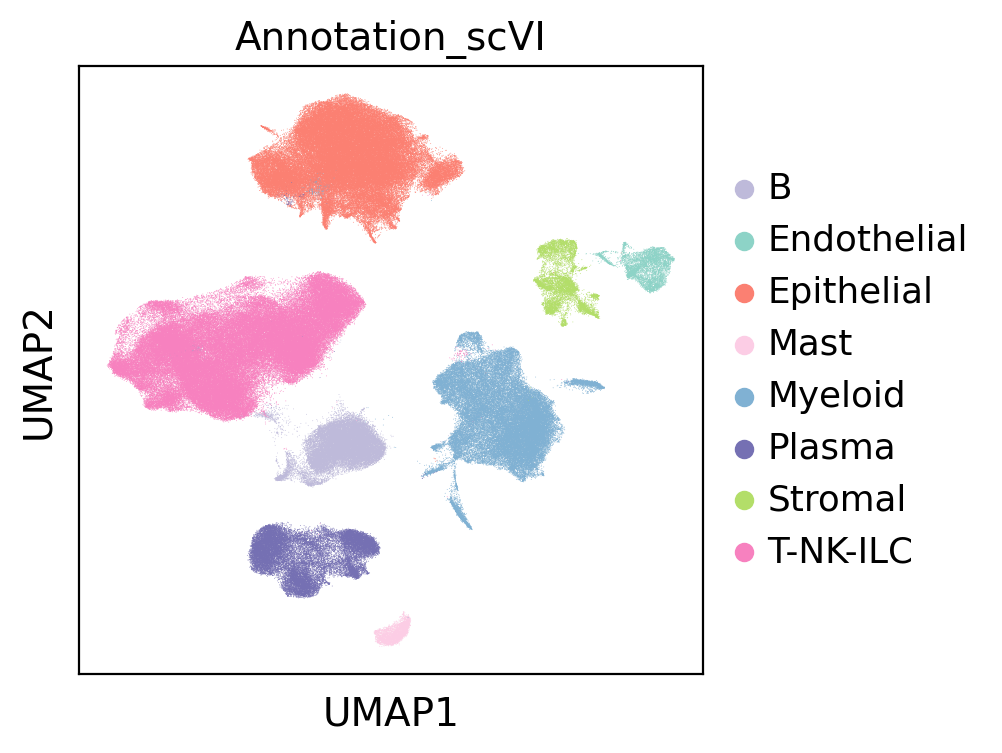

In [21]:
sc.pl.umap(adata, color="Annotation_scVI")

In [23]:
del adata.uns["Annotation_scVI_colors"] # to avoid using it later on

### consider only barcodes that have been annotated by me in TME (10%) and sam cancer cells (20%)

In [24]:
adata[adata.obs.index.isin(barcodes2consider)].obs.Annotation_scVI.value_counts()

T-NK-ILC       94143
Epithelial     60587
Myeloid        37416
Plasma         24514
B              19619
Stromal         5360
Endothelial     3057
Mast            2587
Name: Annotation_scVI, dtype: int64

In [25]:
adata = adata[adata.obs.index.isin(barcodes2consider)].copy()

In [26]:
adata.shape

(247283, 2000)

### Add cancer cell annotations

In [27]:
adata.obs = adata.obs.merge(right=adata_epi.obs[["Annotation_scVI", "Annotation_scVI_detailed"]],
                            how="left", 
                            right_index=True,
                            left_index=True,
                           suffixes=("", "_epi"))

In [29]:
adata.obs.Annotation_scVI.value_counts() # annotations from 20mt global 

T-NK-ILC       94143
Epithelial     60587
Myeloid        37416
Plasma         24514
B              19619
Stromal         5360
Endothelial     3057
Mast            2587
Name: Annotation_scVI, dtype: int64

In [30]:
adata.obs.Annotation_scVI_epi.value_counts() # sam epi annotations

Epithelial    60526
Name: Annotation_scVI_epi, dtype: int64

Sam annotated 60526 cells as epithelial but 20mt has 60587 cells as epithelial. so 61 cells that don't have epithelial annotations from sam, though they are annotated as epithelial in 20mt. We need to remove these!

In [32]:
adata[(adata.obs.Annotation_scVI=="Epithelial") & (adata.obs.Annotation_scVI_detailed.isna())].obs.Cell_type.value_counts()

Epi                 25
Epithelial          11
TNKILC               6
Strom                4
Epithelial cells     3
T cells              3
Myeloid              2
NEU                  2
T/NK/ILC             2
B                    1
CD4                  1
Stromal              1
Name: Cell_type, dtype: int64

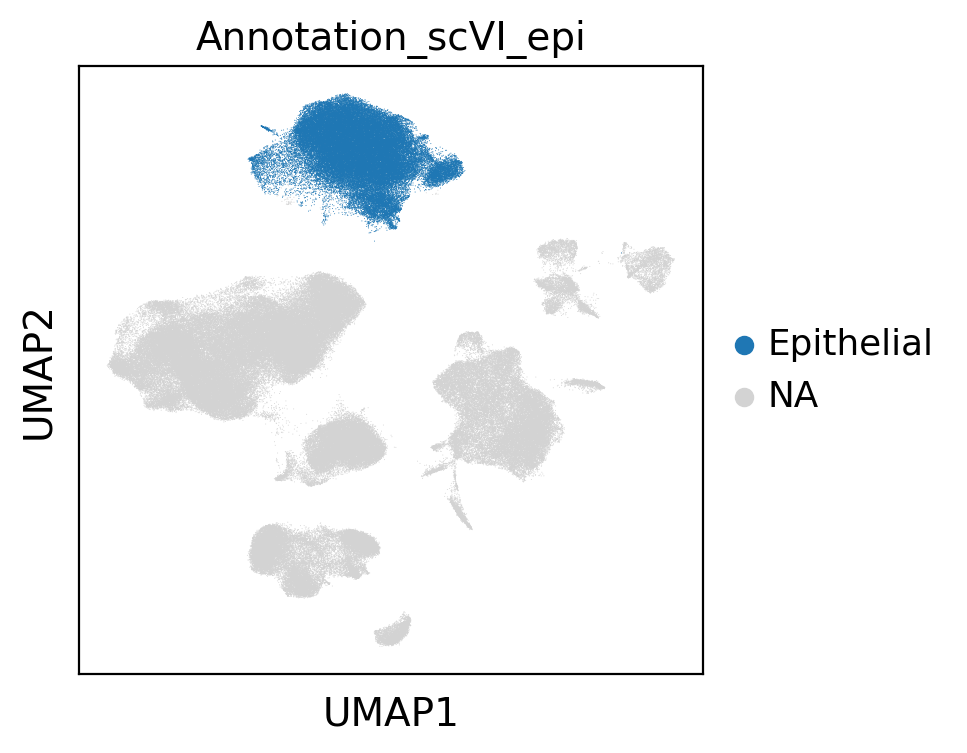

In [33]:
sc.pl.umap(adata, color="Annotation_scVI_epi")

### merge TME annotations

In [34]:
adata.obs = adata.obs.merge(right=adata_tme_annot.obs[["Annotation_scVI", "Annotation_scVI_detailed"]],
                            how="left", 
                            right_index=True,
                            left_index=True,
                           suffixes=("", "_tme"))

In [36]:
### rename column Annotation_scVI to Annotation_scVI_20 so we know that this annotation comes from 20
adata.obs.rename(
    columns={"Annotation_scVI": "Annotation_scVI_20mt",
             "Annotation_scVI_detailed": "Annotation_scVI_detailed_epi"
            }, inplace=True
)

In [38]:
### look at cells that are both annotated by sam and me
adata[(~adata.obs.Annotation_scVI_epi.isna()) & (~adata.obs.Annotation_scVI_tme.isna())].obs

# we keep sam-s annot and major annot with 20mt

Patient              Sample  \
SMC03-T_GCATACACAACGCACC-SMC                   SMC03             SMC03-T   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka  C103_T  C103_T_1_1_0_c1_v2   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka  C129_T  C129_T_1_1_0_c1_v2   

                                                     Cell_type  \
SMC03-T_GCATACACAACGCACC-SMC                  Epithelial cells   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka               Epi   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka               Epi   

                                                            Cell_subtype  \
SMC03-T_GCATACACAACGCACC-SMC                                        CMS1   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka         cE01 (Stem/TA-like)   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka  cE03 (Stem/TA-like prolif)   

                                             Tissue Therapy  doublet_score  \
SMC03-T_GCATACACAACGCACC-SMC                    CRC   naive       0.124088   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka    CRC   naive       0.159170   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka    CRC   naive       0.401993   

                                              predicted_doublet  \
SMC03-T_GCATACACAACGCACC-SMC                              False   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka              False   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka              False   

                                              n_genes_by_counts  total_counts  \
SMC03-T_GCATACACAACGCACC-SMC                               4447       27973.0   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka                723        2346.0   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka               4684       27337.0   

                                              ...   S_score  G2M_score  phase  \
SMC03-T_GCATACACAACGCACC-SMC                  ... -0.097646  -0.057729     G1   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka  ... -0.089780   0.037452    G2M   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka  ... -0.112352  -0.061991     G1   

                                              cell_cycle_diff leiden_scVI  \
SMC03-T_GCATACACAACGCACC-SMC                        -0.039917           1   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka        -0.127232           1   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka        -0.050361           1   

                                              Annotation_scVI_20mt  \
SMC03-T_GCATACACAACGCACC-SMC                            Epithelial   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka            Epithelial   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka            Epithelial   

                                              Annotation_scVI_epi  \
SMC03-T_GCATACACAACGCACC-SMC                           Epithelial   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka           Epithelial   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka           Epithelial   

                                              Annotation_scVI_detailed_epi  \
SMC03-T_GCATACACAACGCACC-SMC                                           TA1   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka                           TA1   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka                          Tuft   

                                              Annotation_scVI_tme  \
SMC03-T_GCATACACAACGCACC-SMC                               Plasma   
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka          Endothelial   
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka          Endothelial   

                                             Annotation_scVI_detailed_tme  
SMC03-T_GCATACACAACGCACC-SMC                                       Plasma  
C103_T_1_1_0_c1_v2_id-CACACTCCAGTTCCCT-Pelka                Tip-like endo  
C129_T_1_1_0_c1_v2_id-GGAAAGCTCAGGTAAA-Pelka                 Endo cycling  

[3 rows x 27 columns]

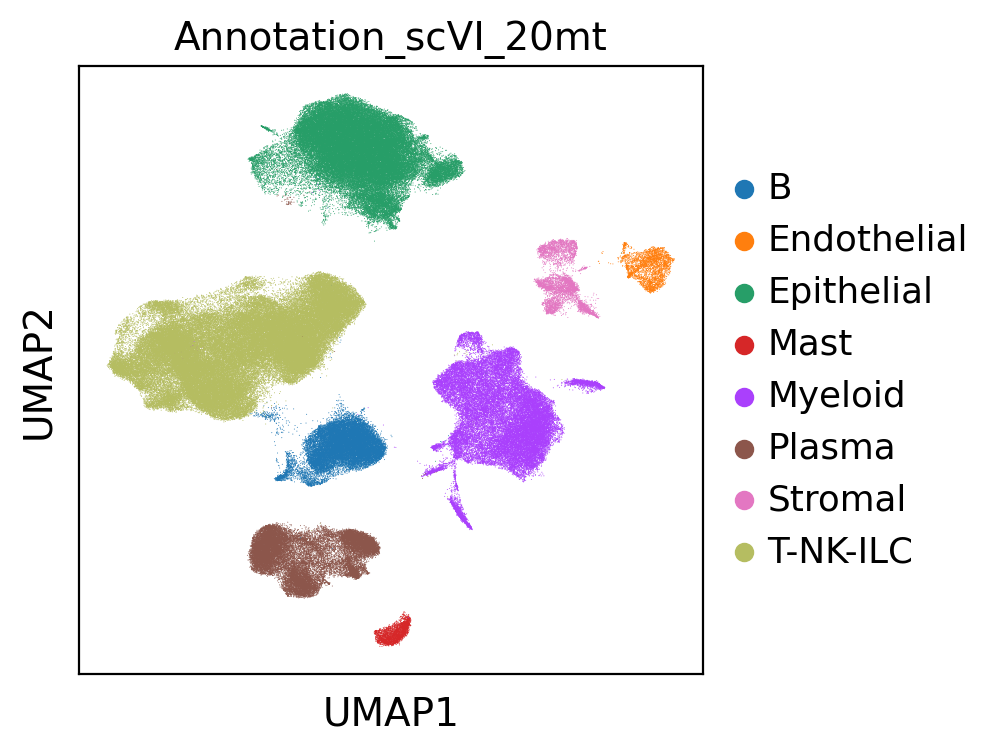

In [39]:
sc.pl.umap(adata, color="Annotation_scVI_20mt")

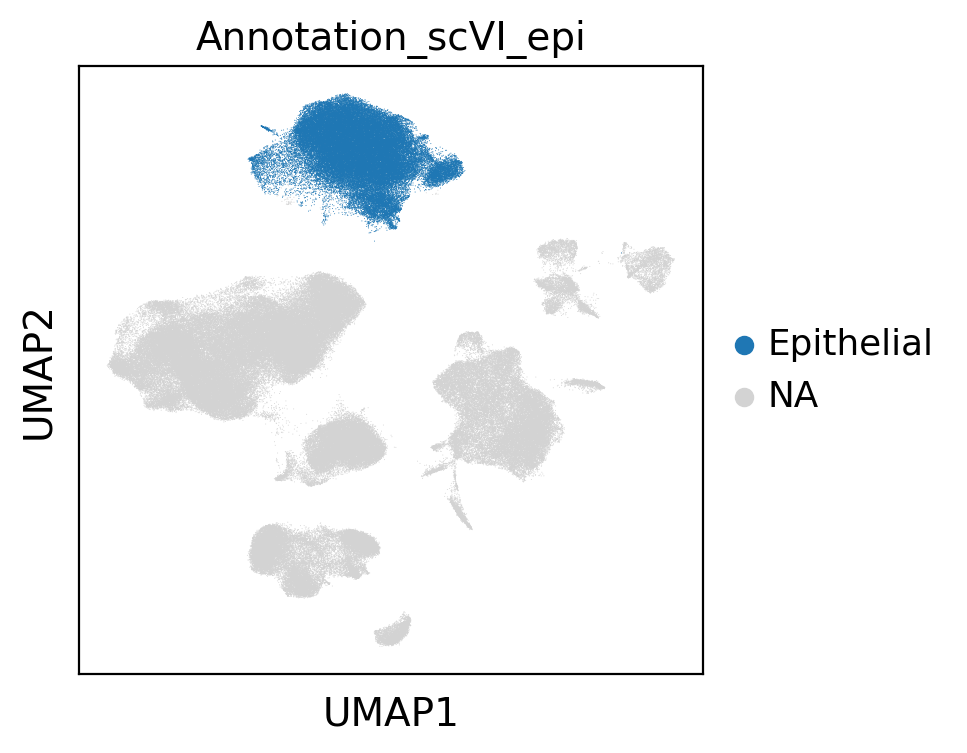

In [40]:
sc.pl.umap(adata, color="Annotation_scVI_epi")

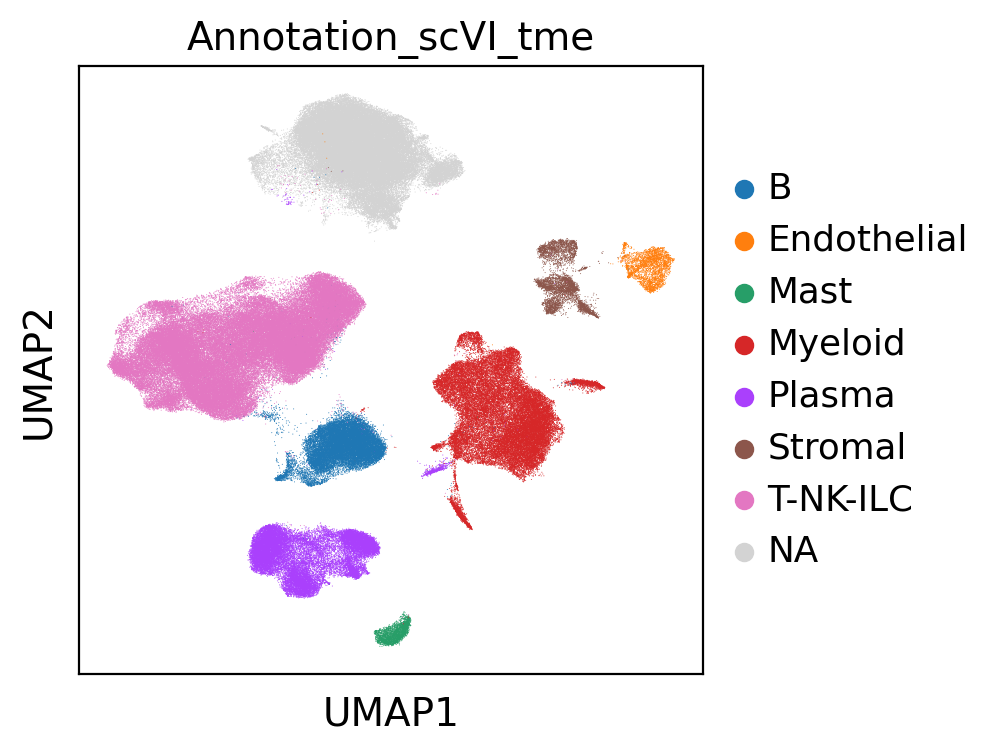

In [41]:
sc.pl.umap(adata, color="Annotation_scVI_tme")

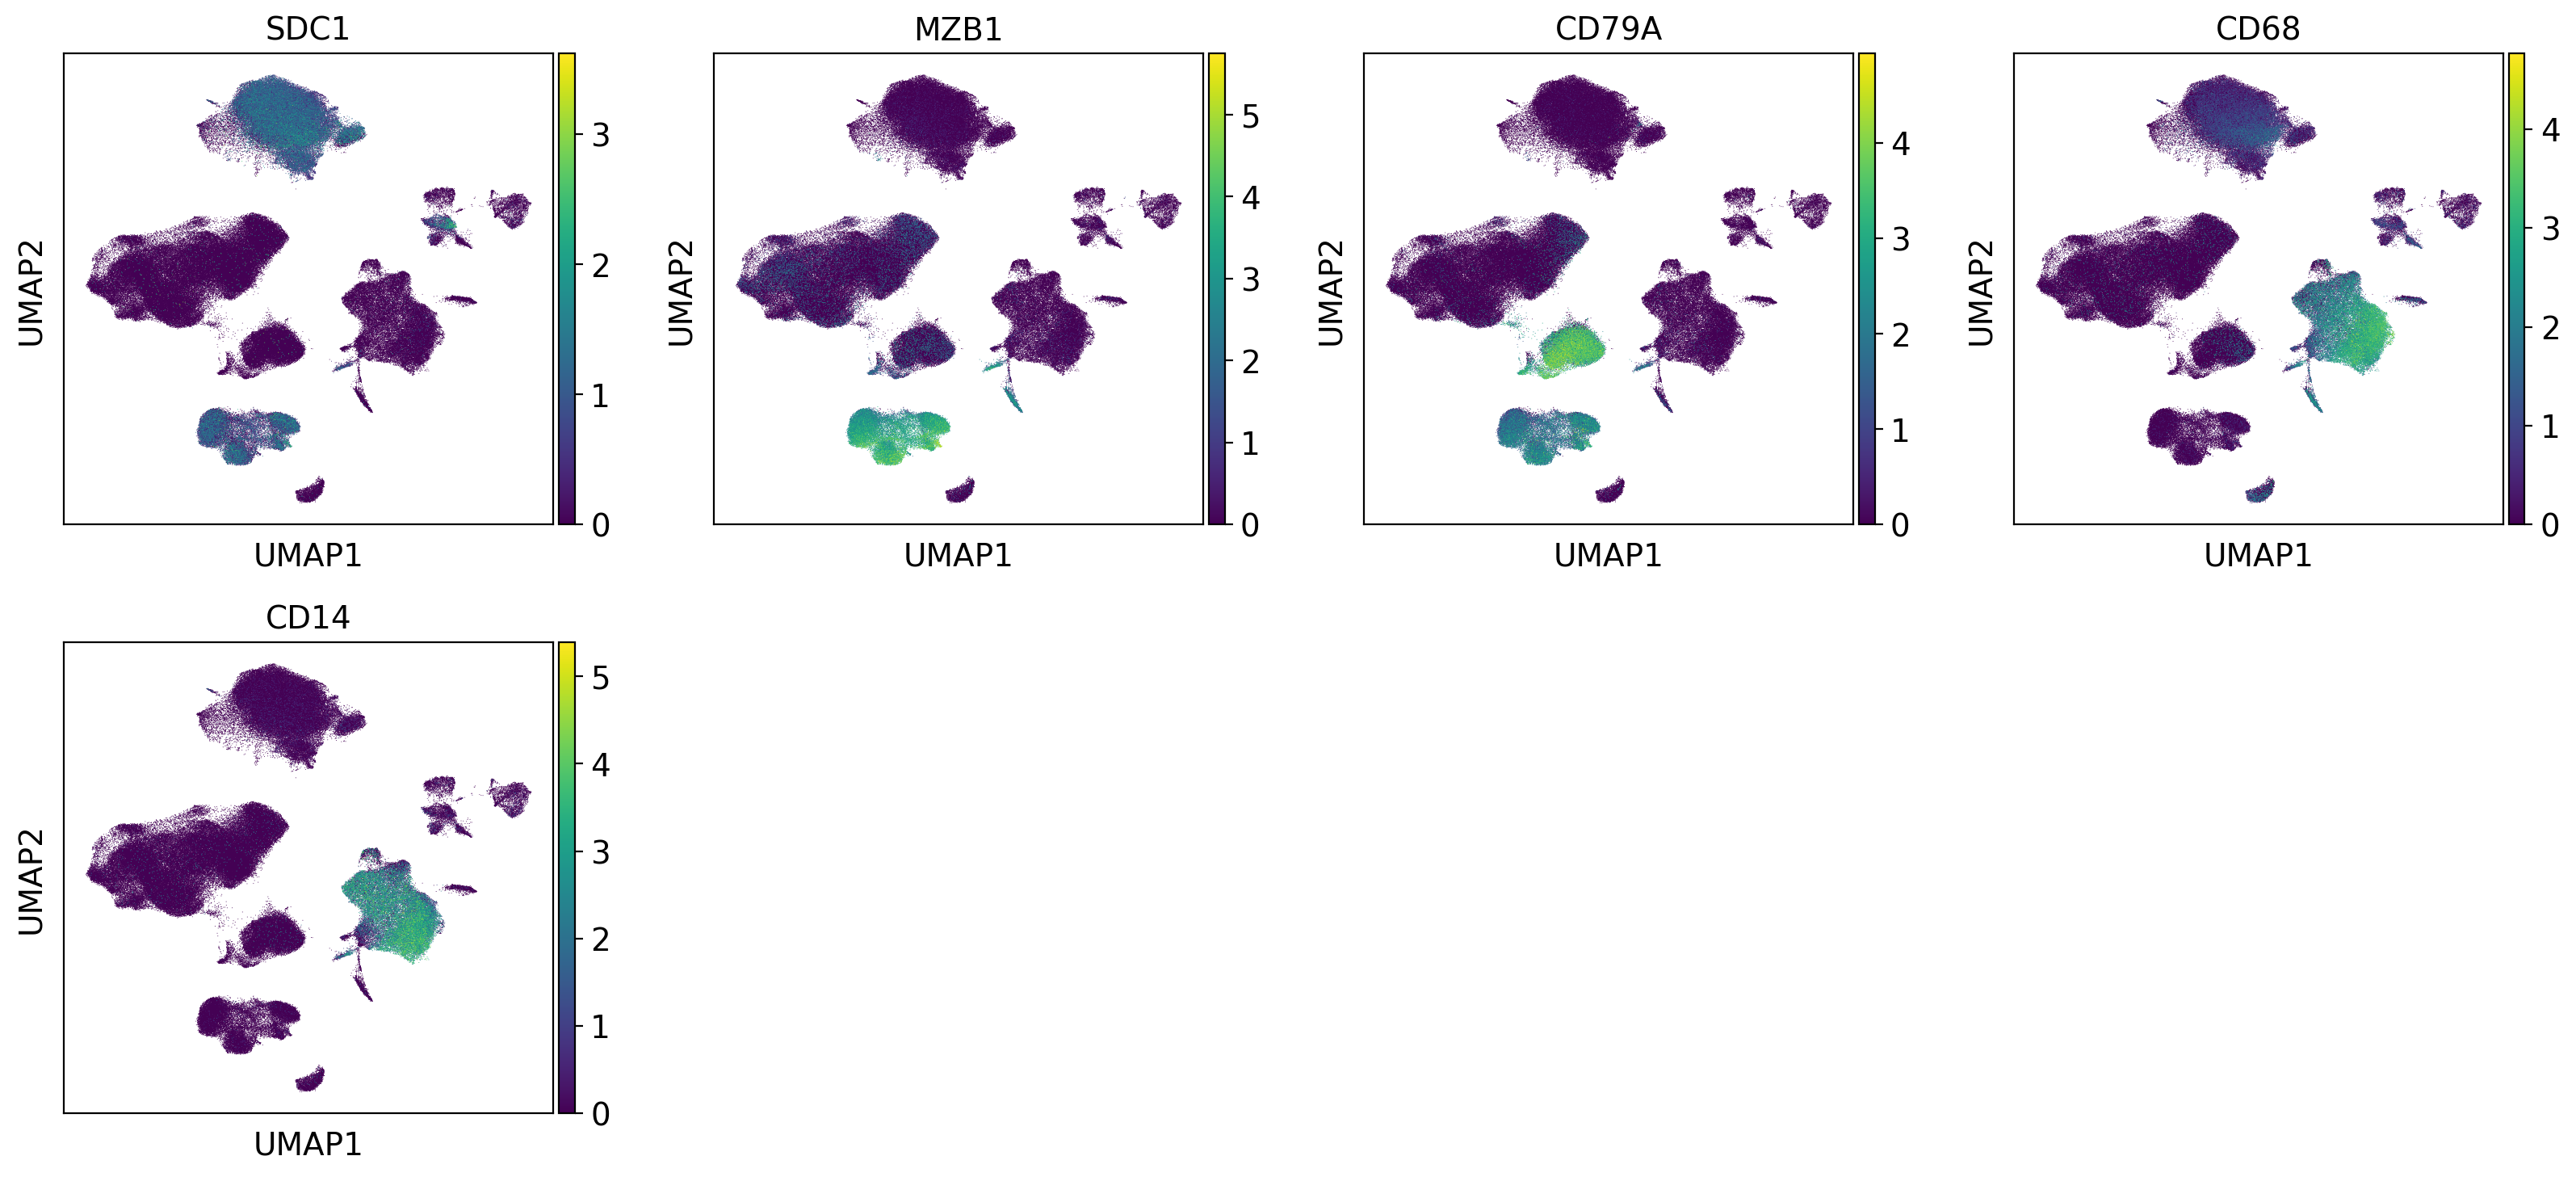

In [42]:
sc.pl.umap(adata, color=["SDC1", "MZB1", "CD79A", "CD68", "CD14"], use_raw=True)

In [43]:
# some cells are plasma and in myeloid -- remove them
adata[(adata.obs.Annotation_scVI_20mt=="Myeloid") & (adata.obs.Annotation_scVI_tme=="Plasma")].obs

Patient       Sample Cell_type  \
SMC03-T_TAAGCGTAGTAAGTAC-SMC            SMC03      SMC03-T  Myeloids   
SMC07-T_AACCATGAGCGCTTAT-SMC            SMC07      SMC07-T  Myeloids   
SMC07-T_AGTAGTCTCAAACAAG-SMC            SMC07      SMC07-T  Myeloids   
SMC07-T_AGTAGTCTCTTAGCCC-SMC            SMC07      SMC07-T  Myeloids   
SMC07-T_CTGTGCTCACGGACAA-SMC            SMC07      SMC07-T  Myeloids   
...                                       ...          ...       ...   
P20_Colon_T_GCCAGCAAGGTAGATT-1-Wu  Wu2021_P20  P20_Colon_T       NEU   
P20_Colon_T_GGAACCCCATGAAGGC-1-Wu  Wu2021_P20  P20_Colon_T   Myeloid   
P20_Colon_T_TGACTCCGTTTCACTT-1-Wu  Wu2021_P20  P20_Colon_T       NEU   
P19_Colon_T_CGAGTGCAGAAATTGC-1-Wu  Wu2021_P19  P19_Colon_T    Plasma   
P19_Colon_T_GTCGTTCGTGATATAG-1-Wu  Wu2021_P19  P19_Colon_T    Plasma   

                                                 Cell_subtype Tissue Therapy  \
SMC03-T_TAAGCGTAGTAAGTAC-SMC                            SPP1+    CRC   naive   
SMC07-T_AACCATGAGCGCTTAT-SMC                            SPP1+    CRC   naive   
SMC07-T_AGTAGTCTCAAACAAG-SMC                 Pro-inflammatory    CRC   naive   
SMC07-T_AGTAGTCTCTTAGCCC-SMC                            SPP1+    CRC   naive   
SMC07-T_CTGTGCTCACGGACAA-SMC                            SPP1+    CRC   naive   
...                                                       ...    ...     ...   
P20_Colon_T_GCCAGCAAGGTAGATT-1-Wu                 Neutrophils    CRC     NAC   
P20_Colon_T_GGAACCCCATGAAGGC-1-Wu  SPP1+ Activated Macrophage    CRC     NAC   
P20_Colon_T_TGACTCCGTTTCACTT-1-Wu                 Neutrophils    CRC     NAC   
P19_Colon_T_CGAGTGCAGAAATTGC-1-Wu        IGHG+ Plasma B cells    CRC     NAC   
P19_Colon_T_GTCGTTCGTGATATAG-1-Wu        IGHA+ Plasma B cells    CRC     NAC   

                                   doublet_score  predicted_doublet  \
SMC03-T_TAAGCGTAGTAAGTAC-SMC            0.184466              False   
SMC07-T_AACCATGAGCGCTTAT-SMC            0.566265              False   
SMC07-T_AGTAGTCTCAAACAAG-SMC            0.419355              False   
SMC07-T_AGTAGTCTCTTAGCCC-SMC            0.284768              False   
SMC07-T_CTGTGCTCACGGACAA-SMC            0.637584              False   
...                                          ...                ...   
P20_Colon_T_GCCAGCAAGGTAGATT-1-Wu       0.205882              False   
P20_Colon_T_GGAACCCCATGAAGGC-1-Wu       0.117647              False   
P20_Colon_T_TGACTCCGTTTCACTT-1-Wu       0.294118               True   
P19_Colon_T_CGAGTGCAGAAATTGC-1-Wu       0.121951              False   
P19_Colon_T_GTCGTTCGTGATATAG-1-Wu       0.209302              False   

                                   n_genes_by_counts  total_counts  ...  \
SMC03-T_TAAGCGTAGTAAGTAC-SMC                    1173        3806.0  ...   
SMC07-T_AACCATGAGCGCTTAT-SMC                    2793       18359.0  ...   
SMC07-T_AGTAGTCTCAAACAAG-SMC                    1581        8762.0  ...   
SMC07-T_AGTAGTCTCTTAGCCC-SMC                    2817       15940.0  ...   
SMC07-T_CTGTGCTCACGGACAA-SMC                    3585       25548.0  ...   
...                                              ...           ...  ...   
P20_Colon_T_GCCAGCAAGGTAGATT-1-Wu                400         722.0  ...   
P20_Colon_T_GGAACCCCATGAAGGC-1-Wu                460         802.0  ...   
P20_Colon_T_TGACTCCGTTTCACTT-1-Wu                385         650.0  ...   
P19_Colon_T_CGAGTGCAGAAATTGC-1-Wu               1575       18289.0  ...   
P19_Colon_T_GTCGTTCGTGATATAG-1-Wu               1649       12068.0  ...   

                                    S_score  G2M_score  phase  \
SMC03-T_TAAGCGTAGTAAGTAC-SMC      -0.013964  -0.089021     G1   
SMC07-T_AACCATGAGCGCTTAT-SMC      -0.122800  -0.091752     G1   
SMC07-T_AGTAGTCTCAAACAAG-SMC      -0.090938  -0.124786     G1   
SMC07-T_AGTAGTCTCTTAGCCC-SMC      -0.120945  -0.160618     G1   
SMC07-T_CTGTGCTCACGGACAA-SMC      -0.110540  -0.088944     G1   
...                                     ...        ...    ...   
P20

In [45]:
adata.obs.Annotation_scVI_20mt.value_counts()

T-NK-ILC       94143
Epithelial     60587
Myeloid        37416
Plasma         24514
B              19619
Stromal         5360
Endothelial     3057
Mast            2587
Name: Annotation_scVI_20mt, dtype: int64

In [46]:
adata.obs.Annotation_scVI_tme.value_counts()

T-NK-ILC       94164
Myeloid        36906
Plasma         24978
B              19703
Stromal         5370
Endothelial     3051
Mast            2588
Name: Annotation_scVI_tme, dtype: int64

### Create new columns of annotations grouping mine and sam's

In [47]:
# create new column of annotation_scVI and annotation_scVI_detailed
adata.obs["Annotation_scVI"] = adata.obs["Annotation_scVI_epi"].copy()
adata.obs["Annotation_scVI_detailed"] = adata.obs["Annotation_scVI_detailed_epi"].copy()

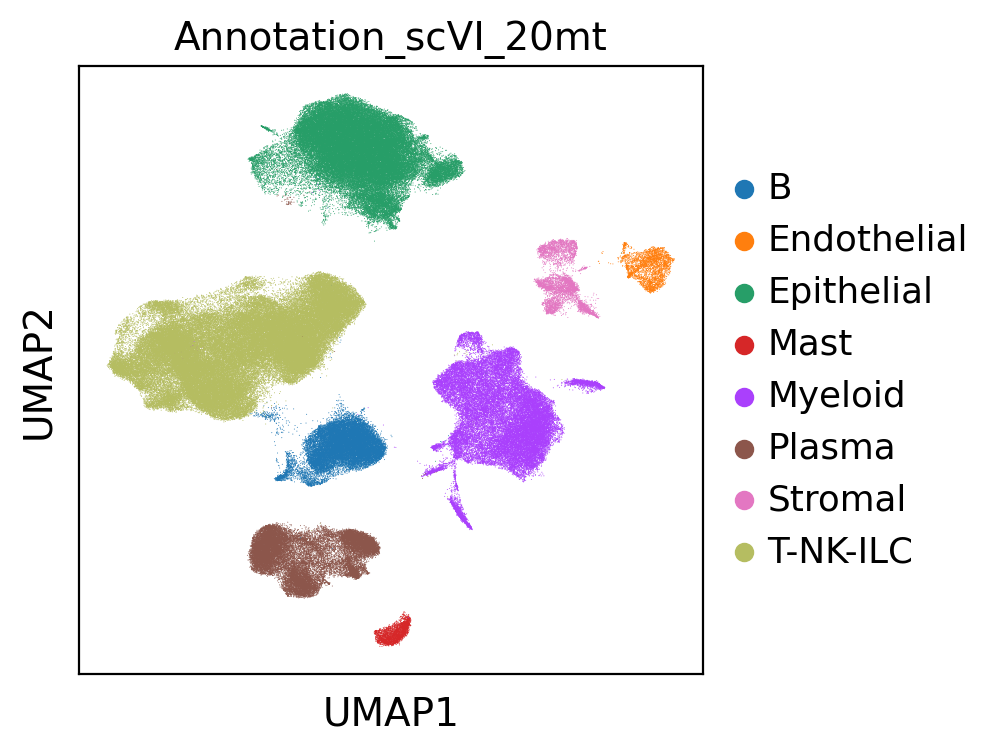

In [48]:
sc.pl.umap(adata, color="Annotation_scVI_20mt")

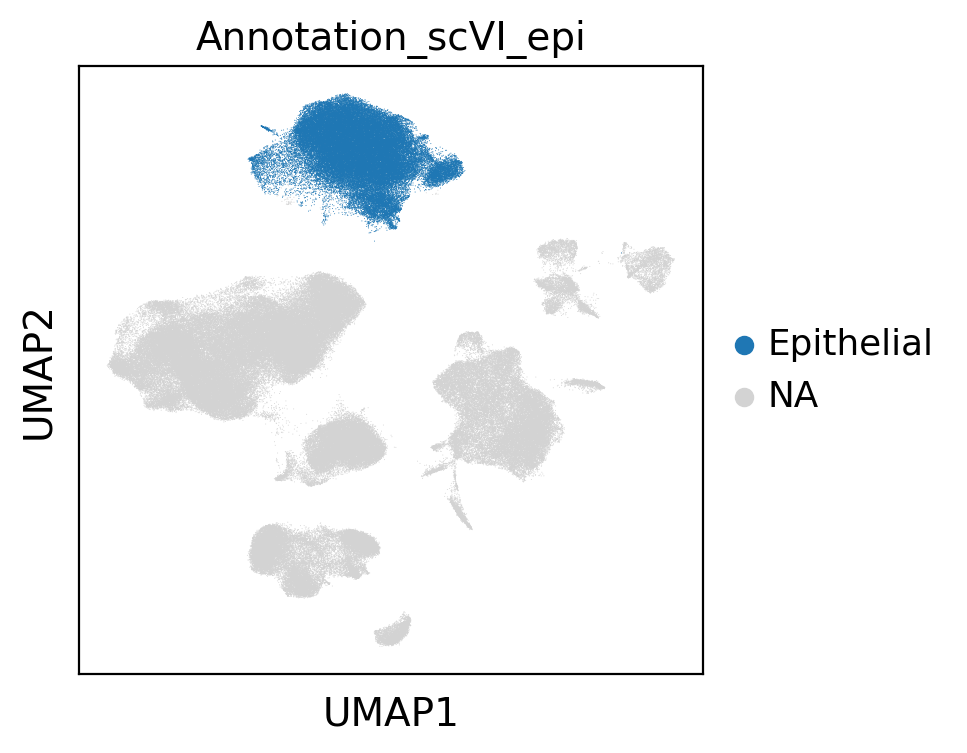

In [49]:
sc.pl.umap(adata, color="Annotation_scVI_epi")

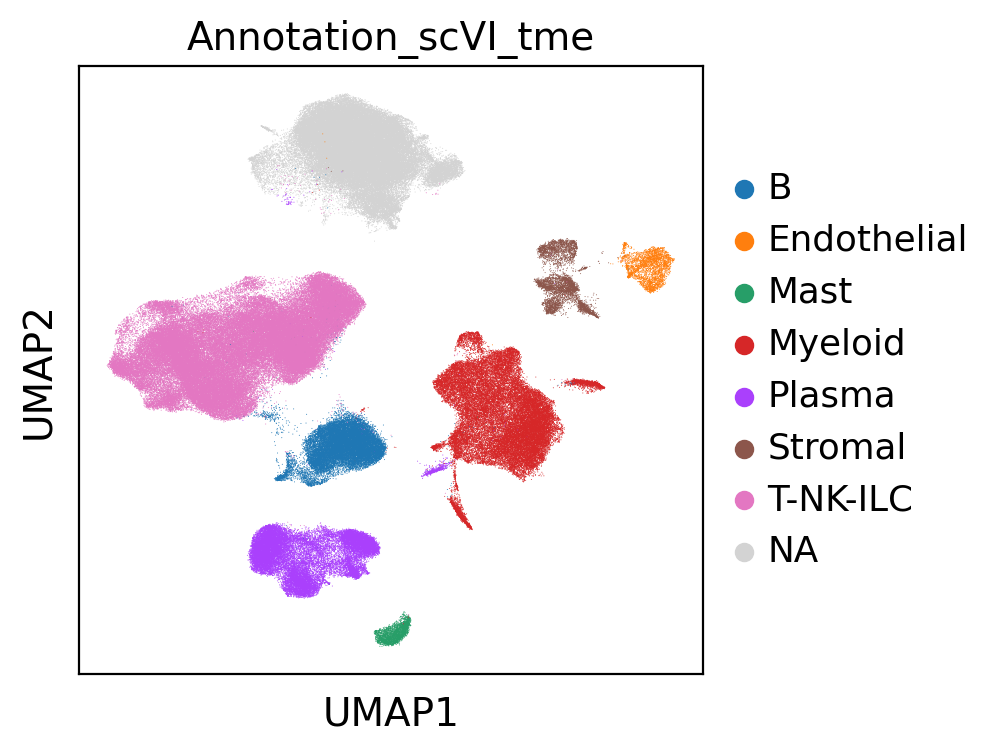

In [50]:
sc.pl.umap(adata, color="Annotation_scVI_tme")

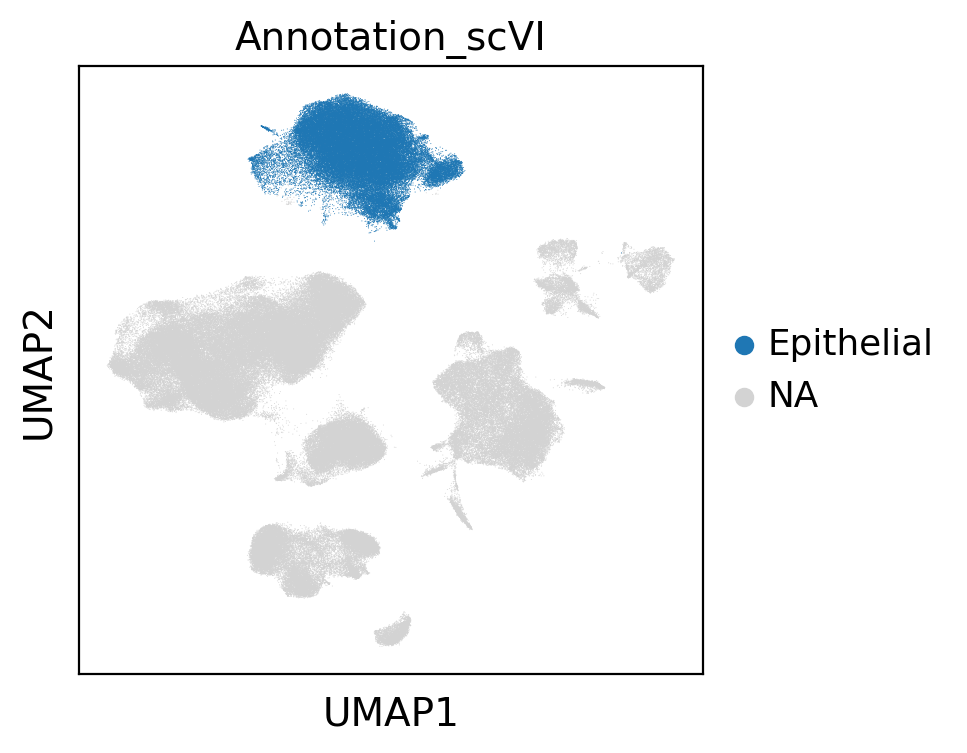

In [51]:
sc.pl.umap(adata, color="Annotation_scVI")

In [52]:
### add major annotations of tme to major annotations of epi
adata.obs["Annotation_scVI"] = np.where(adata.obs["Annotation_scVI"].isna(),
                                            adata.obs["Annotation_scVI_tme"],
                                            adata.obs["Annotation_scVI"]
                                           )

In [53]:
adata.obs.Annotation_scVI.value_counts()

T-NK-ILC       94164
Epithelial     60526
Myeloid        36906
Plasma         24977
B              19703
Stromal         5370
Endothelial     3049
Mast            2588
Name: Annotation_scVI, dtype: int64

In [54]:
adata.obs.Annotation_scVI_epi.value_counts()

Epithelial    60526
Name: Annotation_scVI_epi, dtype: int64

In [55]:
adata.obs.Annotation_scVI_tme.value_counts()

T-NK-ILC       94164
Myeloid        36906
Plasma         24978
B              19703
Stromal         5370
Endothelial     3051
Mast            2588
Name: Annotation_scVI_tme, dtype: int64

In [56]:
adata.obs.Annotation_scVI_20mt.value_counts()

T-NK-ILC       94143
Epithelial     60587
Myeloid        37416
Plasma         24514
B              19619
Stromal         5360
Endothelial     3057
Mast            2587
Name: Annotation_scVI_20mt, dtype: int64

In [61]:
# plasma cells annotated as plasma by me, grouped a bit with myeloid with 20mt
adata[(adata.obs.Annotation_scVI_20mt=="Myeloid") & (adata.obs.Annotation_scVI_tme=="Plasma")].obs.cell_source.value_counts()

Pelka    372
Che       48
SMC       11
Wu        10
KUL        2
Name: cell_source, dtype: int64

In [62]:
# Epithelial cells that haven't been annotated by sam
adata[(adata.obs.Annotation_scVI_20mt=="Epithelial") & (adata.obs.Annotation_scVI_detailed_epi.isna())].obs.Annotation_scVI_detailed_tme.value_counts()

T cycling        20
CD4 Tn           13
Plasma            8
CD4 Th HSP        4
Treg HSP          3
B                 2
Endo cycling      2
Enteric glial     2
C3 iCAF           1
CD4 Tfh           1
CD8 Tem           1
CD8 Tex           1
NK1               1
Neutrophil        1
Treg              1
Name: Annotation_scVI_detailed_tme, dtype: int64

### Based on this I would remove:
* cells that are labelled "Plasma" by me and "Myeloid" in 20mt
* cells that are labelled "Epithelial" in 20mt but don't have sam's annotations (labelled as TME in 10mt)

In [63]:
# some cells are plasma and in myeloid -- remove them
plasma_myeloid2remove = adata[(adata.obs.Annotation_scVI_20mt=="Myeloid") & (adata.obs.Annotation_scVI_tme=="Plasma")].obs.index
print(plasma_myeloid2remove.shape)
adata = adata[~adata.obs.index.isin(plasma_myeloid2remove)].copy()

(443,)


In [64]:
# cells labelled as epi in 20mt but not annotated by Sam 
epi2remove = adata[(adata.obs.Annotation_scVI_20mt=="Epithelial") & (adata.obs.Annotation_scVI_detailed_epi.isna())].obs.index
print(epi2remove.shape)
adata = adata[~adata.obs.index.isin(epi2remove)].copy()

(61,)


In [65]:
adata.obs.Annotation_scVI_20mt.value_counts()

T-NK-ILC       94143
Epithelial     60526
Myeloid        36973
Plasma         24514
B              19619
Stromal         5360
Endothelial     3057
Mast            2587
Name: Annotation_scVI_20mt, dtype: int64

In [66]:
adata.obs.Annotation_scVI_tme.value_counts()

T-NK-ILC       94119
Myeloid        36905
Plasma         24527
B              19701
Stromal         5367
Endothelial     3049
Mast            2588
Name: Annotation_scVI_tme, dtype: int64

In [67]:
adata.obs.Annotation_scVI_epi.value_counts()

Epithelial    60526
Name: Annotation_scVI_epi, dtype: int64

In [68]:
adata.obs[["Annotation_scVI_20mt", "Annotation_scVI_tme", "Annotation_scVI_detailed_epi"]].groupby(["Annotation_scVI_20mt", "Annotation_scVI_tme"]).size()

Annotation_scVI_20mt  Annotation_scVI_tme
B                     B                      19518
                      Endothelial                0
                      Mast                       0
                      Myeloid                   24
                      Plasma                    10
                      Stromal                    0
                      T-NK-ILC                  67
Endothelial           B                          1
                      Endothelial             3044
                      Mast                       0
                      Myeloid                    0
                      Plasma                     0
                      Stromal                   11
                      T-NK-ILC                   1
Epithelial            B                          0
                      Endothelial                2
                      Mast                       0
                      Myeloid                    0
                      Plasma            

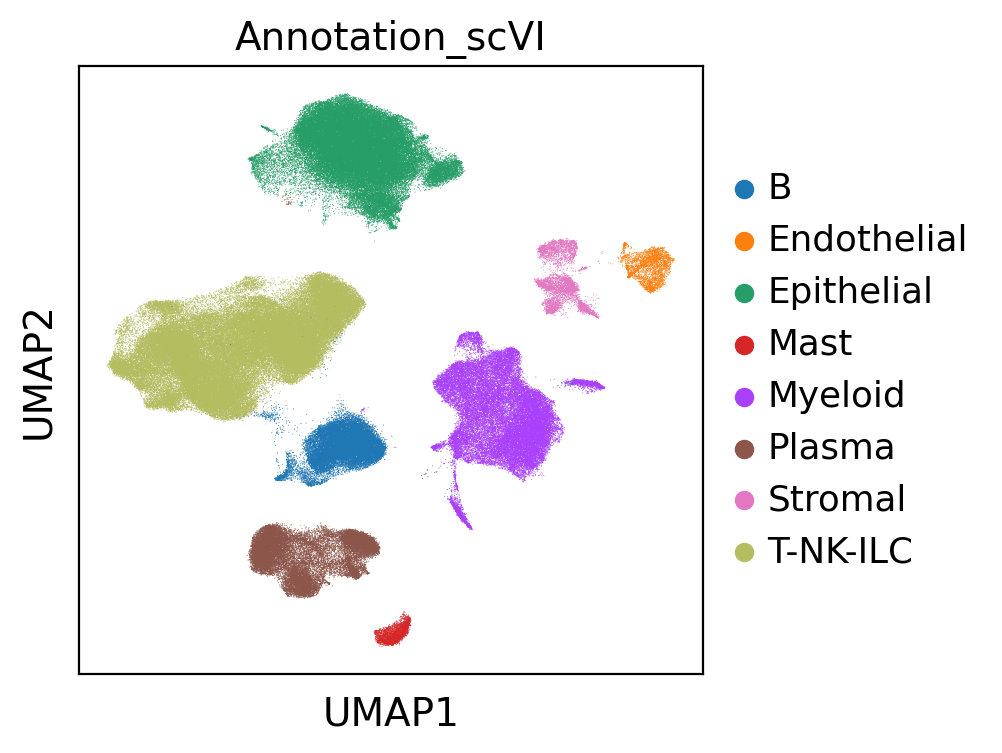

In [69]:
sc.pl.umap(adata, color="Annotation_scVI")

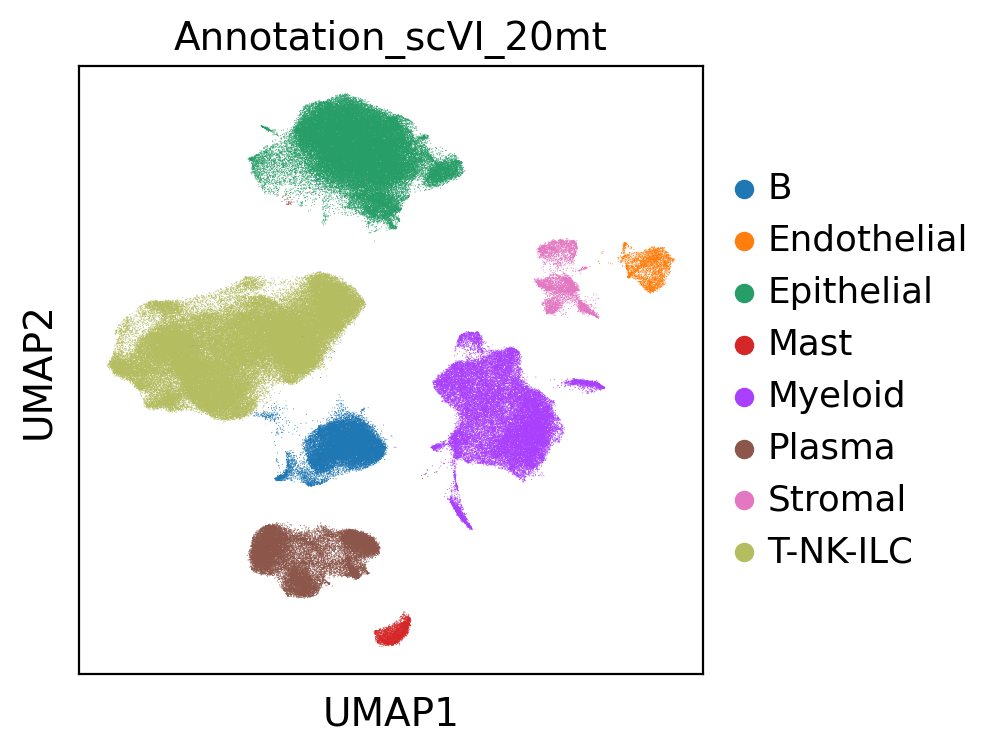

In [70]:
sc.pl.umap(adata, color="Annotation_scVI_20mt")

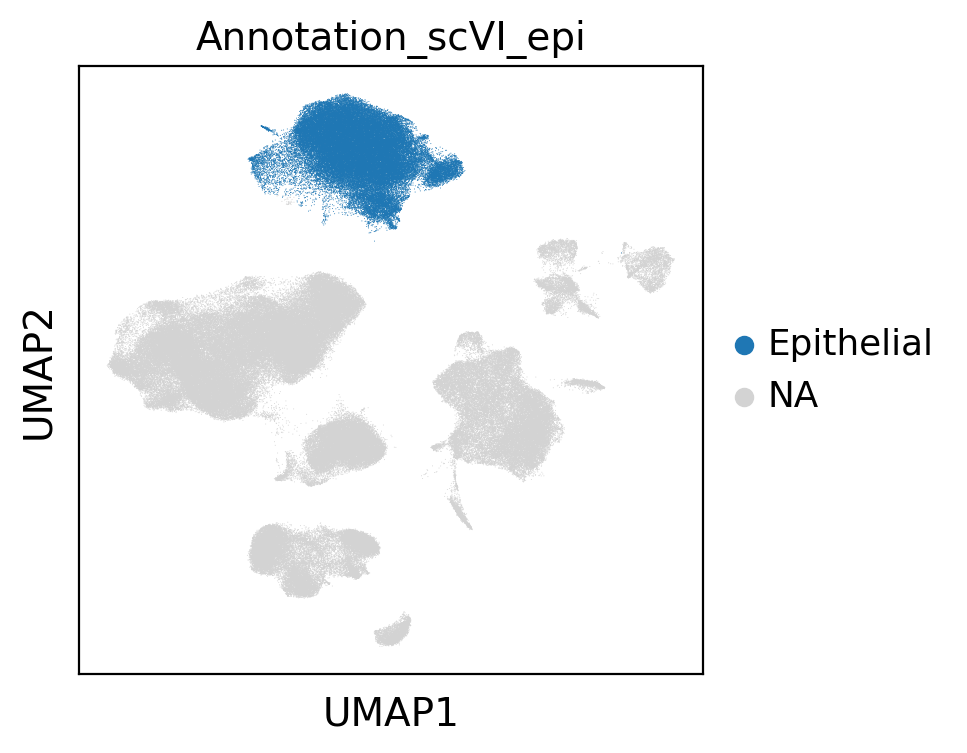

In [71]:
sc.pl.umap(adata, color="Annotation_scVI_epi")

In [72]:
# add tme annotations detailed
adata.obs["Annotation_scVI_detailed"] = np.where(adata.obs["Annotation_scVI_detailed"].isna(),
                                                 adata.obs["Annotation_scVI_detailed_tme"],
                                                 adata.obs["Annotation_scVI_detailed"]
                                                )

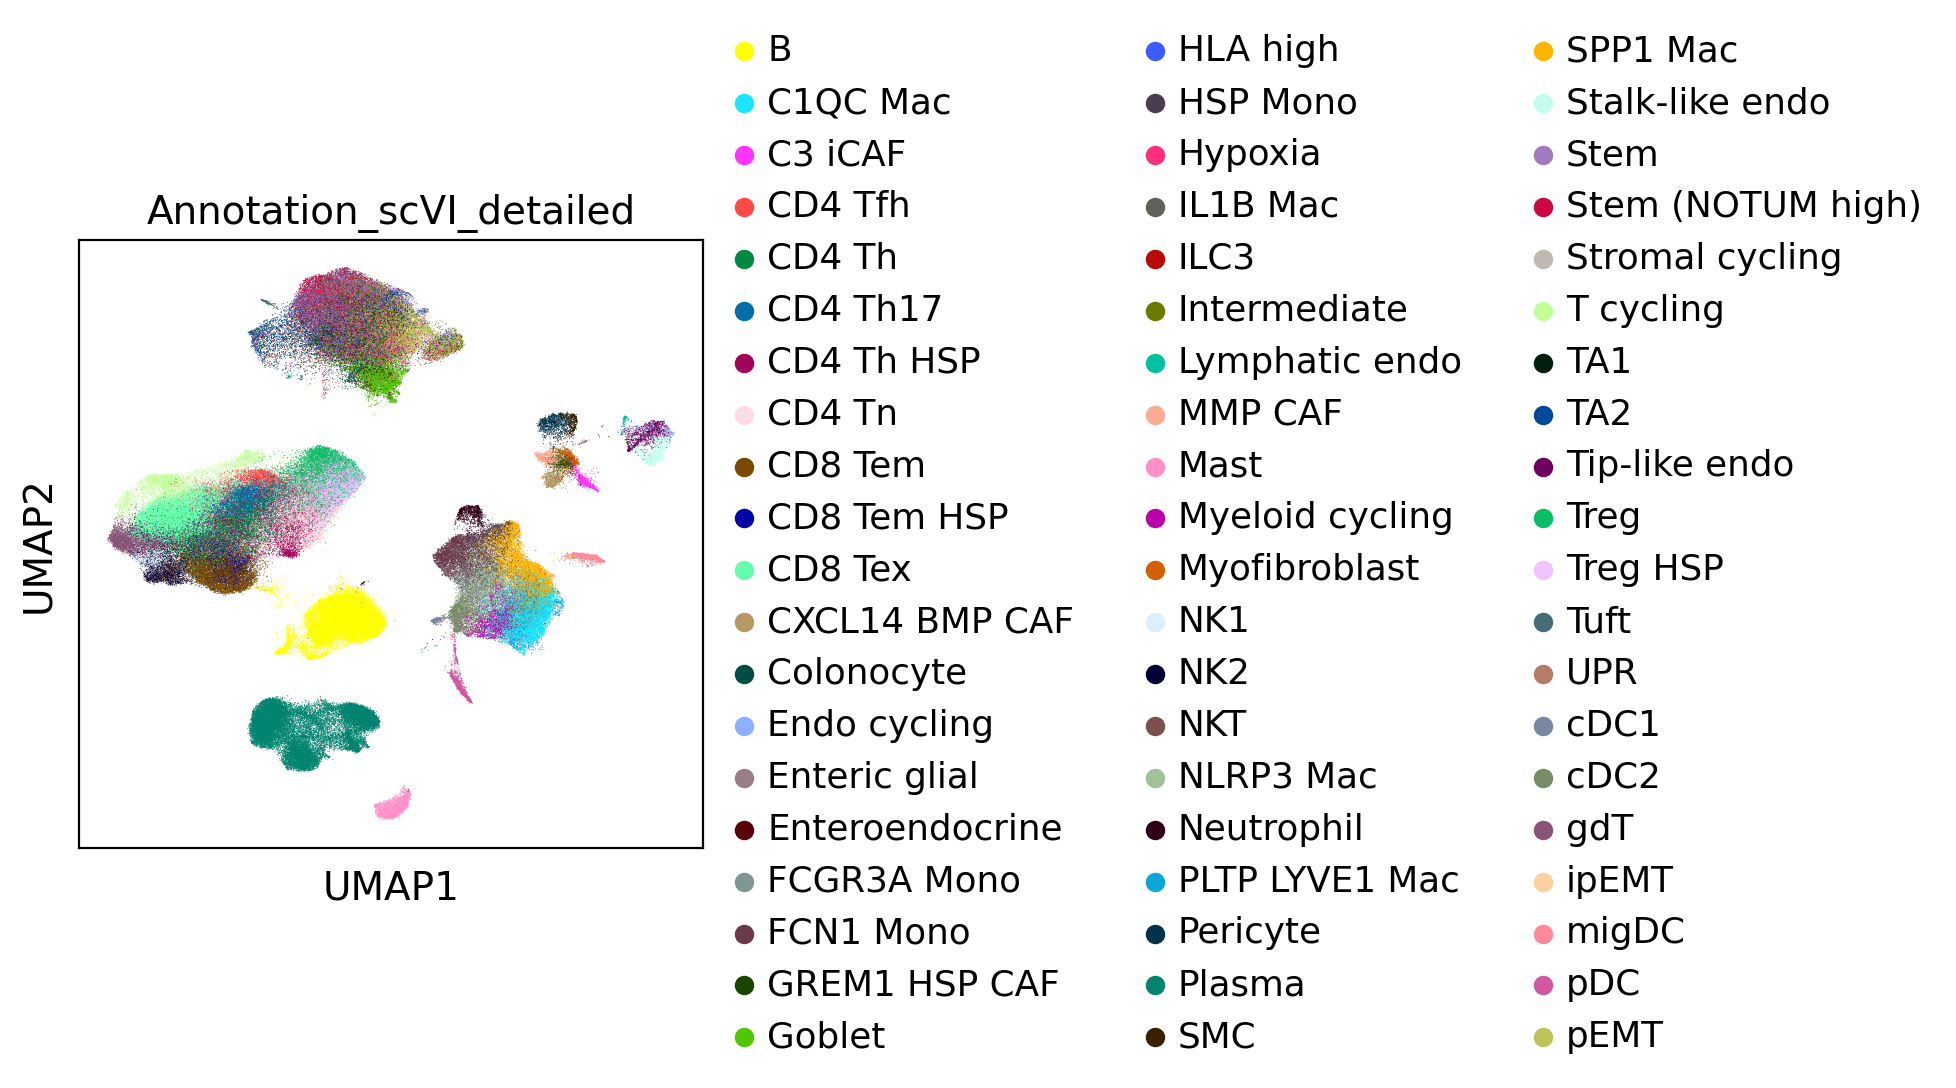

In [73]:
sc.pl.umap(adata, color="Annotation_scVI_detailed")

In [74]:
adata.obs.Annotation_scVI.value_counts()

T-NK-ILC       94119
Epithelial     60526
Myeloid        36905
Plasma         24526
B              19701
Stromal         5367
Endothelial     3047
Mast            2588
Name: Annotation_scVI, dtype: int64

# Set colours for plotting Annotations global

In [91]:
adata.obs.Annotation_scVI.cat.categories

Index(['B', 'Endothelial', 'Epithelial', 'Mast', 'Myeloid', 'Plasma',
       'Stromal', 'T-NK-ILC'],
      dtype='object')

In [92]:
pal_dict = {"B": "#BEBADA",
            "Endothelial": "#8DD3C7",
            "Epithelial": "#FB8072",#E41A1C #FB8072
            #"Hepatocyte": "#FDB462",
            "Mast": "#fccde5", #"#000000",
            "Myeloid": "#80B1D3",
            "Plasma": "#7570B3",#B3B3B3
            "Stromal": "#B3DE69",
            "T-NK-ILC": "#F781BF"
           }

In [93]:
adata.uns["Annotation_scVI_colors"] = list(pal_dict.values())

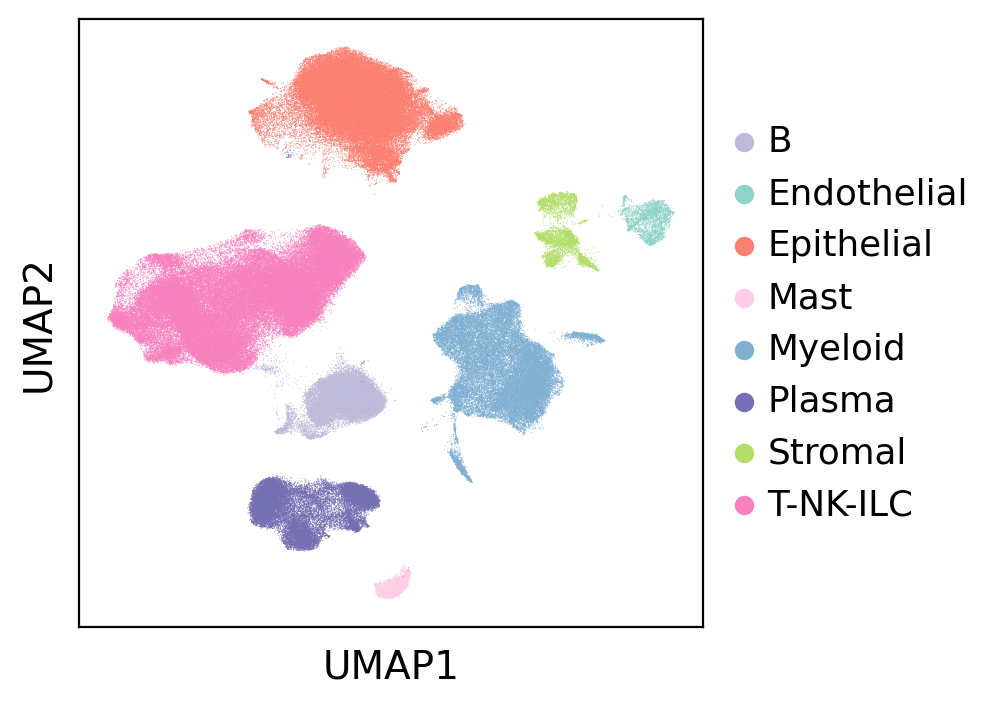

In [94]:
sc.pl.umap(adata, color="Annotation_scVI", title="", save="Annotation_global.pdf")

### Save to file annotations with TME and epi (detailed)

In [95]:
DIR2SAVE

PosixPath('/data/BCI-CRC/nasrine/data/CRC/Primary_CRC_dataset/final_object/20mt')

In [96]:
adata.write(DIR2SAVE.joinpath("SMC_KUL_Pelka_Che_Wu_pCRC_annotations.h5ad"))

In [97]:
adata.shape

(246779, 2000)